In [1]:
import os
import json
#!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
cid ='d8762235995b4ddcbc0df90739df9a63' # Client ID; copy this from your app created on beta.developer.spotify.com
secret = '887a4eccdbde4195bfc0f7f4c472fe70' # Client Secret; copy this from your app
username = '12155311349' # Your Spotify username

#for avaliable scopes see https://developer.spotify.com/web-api/using-scopes/
scope = 'user-library-read playlist-modify-public playlist-read-private'
redirect_uri='https://localhost:8080/callback/'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

token = util.prompt_for_user_token(username,scope,client_id=cid,client_secret=secret,redirect_uri="https://localhost:8080/callback/")
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [3]:
# song_name = input("Search a song for recommendations: ")

# User History Input


In [4]:
short_term_tracks = sp.current_user_top_tracks(time_range='short_term', limit=50)
medium_term_tracks = sp.current_user_top_tracks(time_range='medium_term', limit=50)

# Merge the results and remove duplicates
all_tracks = short_term_tracks['items'] + medium_term_tracks['items']
unique_tracks = {track['id']: track for track in all_tracks}.values()

# Get the audio features for each track
audio_features = {}
for track in unique_tracks:
    audio_features[track['id']] = sp.audio_features(track['id'])[0]

# Create a dataframe with the track information
columns = ['song name', 'artist', 'popularity', 'release date', 'iD', 'danceability', 'energy','loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
data = []
for i, track in enumerate(unique_tracks):
    name = track['name']
    artist = track['artists'][0]['name']
    popularity = track['popularity']
    year = track['album']['release_date'][:4]
    track_id = track['id']
    audio_features = sp.audio_features([track_id])[0]
    danceability = audio_features['danceability']
    loudness = audio_features['loudness']
    energy = audio_features['energy']
    speechiness = audio_features['speechiness']
    acousticness = audio_features['acousticness']
    instrumentalness = audio_features['instrumentalness']
    liveness = audio_features['liveness']
    valence = audio_features['valence']
    tempo = audio_features['tempo']
    data.append([name, artist, popularity, year, track_id, danceability, loudness,energy, speechiness, acousticness, instrumentalness, liveness, valence, tempo])
df = pd.DataFrame(data, columns=columns)

# Scale between 0 and 1
df["tempo"] = (df["tempo"] / df["tempo"].max())
df["loudness"] = (df["loudness"] / df["loudness"].max())
df["energy"] = (df["energy"] / df["energy"].min())
df["popularity"] = (df["popularity"] / 100)

In [5]:
df

,song name,artist,popularity,release date,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Sorry 4 What? // LV BELT,Tory Lanez,0.68,2022,0AyA2lHB4YnQUNa8Y6NNjm,0.652,0.372264,0.706070,0.0628,0.019900,0.000000,0.1320,0.2800,0.617126
1,Search & Rescue,Drake,0.91,2023,7aRCf5cLOFN1U7kvtChY1G,0.817,0.390013,0.468584,0.0734,0.060300,0.000001,0.3300,0.5440,0.696698
2,The Color Violet,Tory Lanez,0.89,2021,3azJifCSqg9fRij2yKIbWz,0.645,0.496597,0.568690,0.0479,0.157000,0.000000,0.0863,0.4630,0.515175
3,Origami (Hotties),Rae Sremmurd,0.64,2023,4euN0XE8wuVc5UHyhMU8uN,0.972,0.325961,0.430245,0.0658,0.018200,0.000061,0.1920,0.0853,0.616130
4,Lovers Rock,TV Girl,0.89,2014,6dBUzqjtbnIa1TwYbyw5CM,0.559,0.245448,0.927583,0.0397,0.000008,0.005450,0.0960,0.5720,0.514930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,Monks,Frank Ocean,0.66,2012,0msrDPXxZpts4FRnoX0bFr,0.747,0.218089,0.807242,0.1790,0.052100,0.000000,0.2140,0.6010,0.500459
85,N Side,Steve Lacy,0.76,2019,12ILYlOEfWL8ei0BEgFJn0,0.838,0.289820,0.569755,0.0432,0.071400,0.000302,0.2080,0.8940,0.588395
86,Major Distribution,Drake,0.79,2022,46s57QULU02Voy0Kup6UEb,0.908,0.482389,0.581470,0.3230,0.012700,0.000000,0.0707,0.2250,0.642698
87,Helluva Price,Gunna,0.61,2018,5bFym95c4l7Q7cVIYArOzC,0.865,0.466894,0.407881,0.2520,0.579000,0.000000,0.1270,0.2450,0.662482


# Getting Recommendations 

In [6]:
recom = []

for index, row in df.iterrows():
    # Find similar songs based on audio features, year, and popularity
    similar_songs = sp.recommendations(seed_tracks=[row['iD']], target_popularity=popularity, limit=5, **audio_features)
    recom.append(similar_songs)
        
# Extract relevant info from recommendations and store in DataFrame
columns = ['name', 'artist', 'popularity', 'year', 'iD', 'danceability', 'energy','loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
data = []
for i, track_list in enumerate(recom):
    for track in track_list['tracks']:
        name = track['name']
        artist = track['artists'][0]['name']
        popularity = track['popularity']
        year = track['album']['release_date'][:4]
        track_id = track['id']
        audio_features = sp.audio_features([track_id])[0]
        danceability = audio_features['danceability']
        loudness = audio_features['loudness']
        energy = audio_features['energy']
        speechiness = audio_features['speechiness']
        acousticness = audio_features['acousticness']
        instrumentalness = audio_features['instrumentalness']
        liveness = audio_features['liveness']
        valence = audio_features['valence']
        tempo = audio_features['tempo']
        data.append([name, artist, popularity, year, track_id, danceability, loudness,energy, speechiness, acousticness, instrumentalness, liveness, valence, tempo])
df_recom = pd.DataFrame(data, columns=columns)

# Scale between 0 and 1
df_recom["tempo"] = (df_recom["tempo"] / df_recom["tempo"].max())
df_recom["loudness"] = (df_recom["loudness"] / df_recom["loudness"].max())
df_recom["energy"] = (df_recom["energy"] / df_recom["energy"].min())
df_recom["popularity"] = (df_recom["popularity"] / 100)

df_recom


,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Sorry 4 What? // LV BELT,Tory Lanez,0.68,2022,0AyA2lHB4YnQUNa8Y6NNjm,0.652,0.242722,0.666332,0.0628,0.0199,0.000000,0.132,0.280,0.626468
1,Royal Flush (feat. Young Thug),Rae Sremmurd,0.68,2023,6iN3ICXAJjrNuSAlWMzwz7,0.810,0.149093,0.582915,0.2650,0.1400,0.000028,0.163,0.287,0.637409
2,Shimmy (feat. Joey Bada$$),Logic,0.68,2023,7vL9rAHS2fLo8EjvGvtWr7,0.762,0.186179,0.684422,0.2850,0.1470,0.000000,0.149,0.433,0.767326
3,Mannequin (feat. Lil Tjay),Pop Smoke,0.68,2020,5eJpwQyirY5EEdNadHKRAM,0.683,0.177575,0.803015,0.3000,0.4560,0.000000,0.264,0.752,0.722702
4,No L's,Smino,0.68,2022,12CNybio0Bxean3F3uYugU,0.786,0.194034,0.653266,0.3100,0.1560,0.000000,0.127,0.492,0.652313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,Rhinestone Cowboy,Glen Campbell,0.68,1975,0VwTeYNjcl30DyQlt3GPe0,0.644,0.240024,0.636181,0.0261,0.1020,0.000068,0.227,0.647,0.573633
441,Lyin' Eyes - 2013 Remaster,Eagles,0.68,1975,5lQKRR3MdJLtAwNBiT8Cq0,0.669,0.292430,0.676382,0.0248,0.2030,0.027100,0.164,0.867,0.660714
442,The Things We Do For Love,10cc,0.68,1977,6KEWtSOGKpIXGw6l1uJgsR,0.637,0.294918,0.530653,0.0394,0.1630,0.000000,0.122,0.781,0.532580
443,Joy To The World,Three Dog Night,0.68,1970,2ymeOsYijJz09LfKw3yM2x,0.649,0.375206,0.682412,0.0316,0.4640,0.001210,0.339,0.971,0.631767


C:\Users\zarek\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\zarek\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


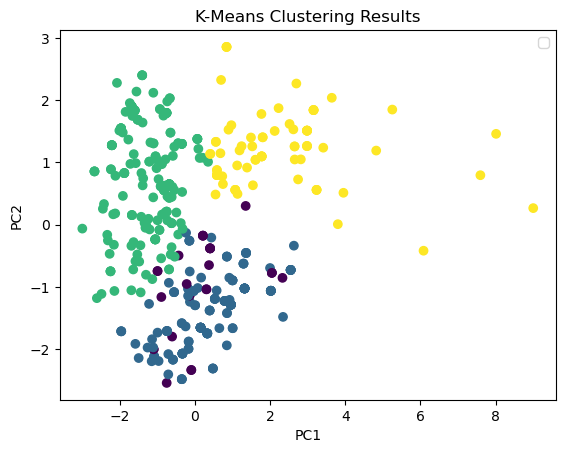

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define the features to use for the model
features = ['year','danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Create a new dataframe with only the features to use for the model
df_model = df_recom[features]

# Scale the features
scaler = StandardScaler()
df_model_scaled = scaler.fit_transform(df_model)

# Fit the K-means model using the new dataframeabs
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_model_scaled)

# Get the cluster labels for each data point
labels = kmeans.labels_
df_recom['clusters'] = labels
# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_model_scaled)

# Plot the data points with different colors based on their cluster labels
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering Results')
plt.legend()
plt.show()

In [14]:
df_recom

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
0,Sorry 4 What? // LV BELT,Tory Lanez,0.68,2022,0AyA2lHB4YnQUNa8Y6NNjm,0.652,0.242722,0.666332,0.0628,0.0199,0.000000,0.132,0.280,0.626468,2
1,Royal Flush (feat. Young Thug),Rae Sremmurd,0.68,2023,6iN3ICXAJjrNuSAlWMzwz7,0.810,0.149093,0.582915,0.2650,0.1400,0.000028,0.163,0.287,0.637409,2
2,Shimmy (feat. Joey Bada$$),Logic,0.68,2023,7vL9rAHS2fLo8EjvGvtWr7,0.762,0.186179,0.684422,0.2850,0.1470,0.000000,0.149,0.433,0.767326,2
3,Mannequin (feat. Lil Tjay),Pop Smoke,0.68,2020,5eJpwQyirY5EEdNadHKRAM,0.683,0.177575,0.803015,0.3000,0.4560,0.000000,0.264,0.752,0.722702,2
4,No L's,Smino,0.68,2022,12CNybio0Bxean3F3uYugU,0.786,0.194034,0.653266,0.3100,0.1560,0.000000,0.127,0.492,0.652313,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,Rhinestone Cowboy,Glen Campbell,0.68,1975,0VwTeYNjcl30DyQlt3GPe0,0.644,0.240024,0.636181,0.0261,0.1020,0.000068,0.227,0.647,0.573633,1
441,Lyin' Eyes - 2013 Remaster,Eagles,0.68,1975,5lQKRR3MdJLtAwNBiT8Cq0,0.669,0.292430,0.676382,0.0248,0.2030,0.027100,0.164,0.867,0.660714,1
442,The Things We Do For Love,10cc,0.68,1977,6KEWtSOGKpIXGw6l1uJgsR,0.637,0.294918,0.530653,0.0394,0.1630,0.000000,0.122,0.781,0.532580,1
443,Joy To The World,Three Dog Night,0.68,1970,2ymeOsYijJz09LfKw3yM2x,0.649,0.375206,0.682412,0.0316,0.4640,0.001210,0.339,0.971,0.631767,1


In [24]:
# filter the data to only include cluster 2 values
cluster_0_data = df_recom[df_recom['clusters']==0]
cluster_1_data = df_recom[df_recom['clusters']==1]
cluster_2_data = df_recom[df_recom['clusters'] == 2]
cluster_3_data = df_recom[df_recom['clusters']==3]

In [28]:
cluster_0_data.head()

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
24,When the Sun Hits,Slowdive,0.68,1993,0oxYB9GoOIDrdzniNdKC44,0.330,0.352691,0.534673,0.0263,0.00101,0.709,0.1010,0.218,0.465667,0
28,So Good At Being in Trouble,Unknown Mortal Orchestra,0.68,2013,2lwi35A2ym3FAmSlvOGnQp,0.829,0.303882,0.437186,0.0515,0.03630,0.881,0.1190,0.594,0.516983,0
40,Away,Vacations,0.68,2016,2NaGl56lq71UMzDSI8jmJ3,0.576,0.171758,0.919598,0.0277,0.01240,0.946,0.0856,0.961,0.552858,0
44,What Would I Do?,Strawberry Guy,0.71,2019,5EJA7Rwkeuvm98CZg0XXNO,0.539,0.230070,0.463317,0.0279,0.45700,0.903,0.0720,0.436,0.640571,0
55,Digital Love,Daft Punk,0.68,2001,2VEZx7NWsZ1D0eJ4uv5Fym,0.644,0.251776,0.667337,0.0332,0.04800,0.867,0.3420,0.530,0.621105,0


In [29]:
cluster_1_data.head()

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
30,Take The Long Way Home - 2010 Remastered,Supertramp,0.68,1979,0v0XYK0pLgsPiq5u4FKHaw,0.414,0.264968,0.703518,0.0301,0.220,0.000721,0.114,0.370,0.382396,1
31,The Things We Do For Love,10cc,0.68,1977,6KEWtSOGKpIXGw6l1uJgsR,0.637,0.294918,0.530653,0.0394,0.163,0.000000,0.122,0.781,0.532580,1
32,Lyin' Eyes - 2013 Remaster,Eagles,0.68,1975,5lQKRR3MdJLtAwNBiT8Cq0,0.669,0.292430,0.676382,0.0248,0.203,0.027100,0.164,0.867,0.660714,1
33,The Air That I Breathe - 2008 Remaster,The Hollies,0.68,1974,6yLIqXX9edg1x0HZS7cZEv,0.279,0.251087,0.475377,0.0309,0.242,0.001640,0.158,0.246,0.835563,1
35,The Things We Do For Love,10cc,0.68,1977,6KEWtSOGKpIXGw6l1uJgsR,0.637,0.294918,0.530653,0.0394,0.163,0.000000,0.122,0.781,0.532580,1


In [30]:
cluster_2_data.head()

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
0,Sorry 4 What? // LV BELT,Tory Lanez,0.68,2022,0AyA2lHB4YnQUNa8Y6NNjm,0.652,0.242722,0.666332,0.0628,0.0199,0.000000,0.132,0.280,0.626468,2
1,Royal Flush (feat. Young Thug),Rae Sremmurd,0.68,2023,6iN3ICXAJjrNuSAlWMzwz7,0.810,0.149093,0.582915,0.2650,0.1400,0.000028,0.163,0.287,0.637409,2
2,Shimmy (feat. Joey Bada$$),Logic,0.68,2023,7vL9rAHS2fLo8EjvGvtWr7,0.762,0.186179,0.684422,0.2850,0.1470,0.000000,0.149,0.433,0.767326,2
3,Mannequin (feat. Lil Tjay),Pop Smoke,0.68,2020,5eJpwQyirY5EEdNadHKRAM,0.683,0.177575,0.803015,0.3000,0.4560,0.000000,0.264,0.752,0.722702,2
4,No L's,Smino,0.68,2022,12CNybio0Bxean3F3uYugU,0.786,0.194034,0.653266,0.3100,0.1560,0.000000,0.127,0.492,0.652313,2


In [31]:
cluster_3_data.head()

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
14,Make You Mine,Giveon,0.68,2022,7r1MqPAD09w24mCUUbxiCI,0.551,0.305621,0.371859,0.0551,0.87000,0.00000,0.1220,0.241,0.683546,3
20,In A Good Way,Faye Webster,0.68,2021,2VYnlKxB8jpbCeLUjQsebc,0.587,0.264998,0.287437,0.0315,0.18500,0.02880,0.2140,0.302,0.354175,3
22,Jobless Monday,Mitski,0.68,2014,3ngZf8e29zHlW4gNMQb6IR,0.434,0.336291,0.444221,0.0300,0.00106,0.01360,0.1230,0.203,0.498070,3
23,How - demo,Clairo,0.68,2018,2lO8mP1QvI7RizGcBYQ7Mx,0.649,0.137431,0.430151,0.0313,0.76600,0.00294,0.0816,0.514,0.383725,3
26,Warned You,Good Morning,0.68,2014,3GahMRXI3rL2JVeSLZBRnF,0.535,0.491740,0.210050,0.0257,0.66800,0.14000,0.1290,0.515,0.686654,3
